In [112]:
import numpy as np
from matplotlib import pyplot as plt
from model import USV
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from utils import *
final_path = np.genfromtxt('turtlebot_positions.csv', delimiter=',', skip_header=1)

# final_path=np.load("/home/gokul/Desktop/iros_baselines/multi-agent/mpc_testing/baseline_dqn/first_optimal_path_with_yaw.npy")


# final_path=np.load('first_optimal_path_with_yaw.npy')
final_path = final_path[::10]
final_path*=15
initial_positions = [(final_path[0][0], final_path[0][1], final_path[0][2])]
final_path = final_path[:,:2]
# final_path = final_path*15

env = USV(
    v=0,
    dt=0.2,
    path_index=0,
    goal=final_path[-1],
    budget=10,
    initial_positions=initial_positions,
    final_paths=[final_path],
)

# model = DQN.load("dqn_communication_optimization_g09_epsfrac075_bs128_steps300k_6090270")

obs, _ = env.reset()
done = False
total_rewards = 0
ep_var = []
# print(env.path_index)
errors = []
# print(errors)
print("-------")
communicate_indices = []
variances = []
car_positions = [[env.car.x, env.car.y]]
comm_interval=len(final_path)//env.initial_budget
traj_errors=[np.linalg.norm([env.car.x_true, env.car.y_true]-final_path[env.path_index])]
while not done:
    # if env.path_index <= 100:
    #     action = 0
    # else:
    if env.path_index % comm_interval == 0:
        action=0
    
    else:
        action=0
    # action, _states = model.predict(
        # obs[:5], deterministic=True
    # )  # Use the model to predict the action
    # action = 1
    # print(f"action: {action}")
    if action == 1:
        communicate_indices.append(env.path_index)

    # print(f"action: {action}")
    # ep_var.append(np.linalg.norm(env.car.pf_var))
    errors.append(
        np.linalg.norm(
            np.array([env.car.x, env.car.y]) - np.array([env.car.x_true, env.car.y_true])
        ))
    variances.append(np.linalg.norm(env.car.pf_var))
    traj_errors.append(np.linalg.norm([env.car.x_true, env.car.y_true]-final_path[env.path_index]))
    obs, rewards, terminated, truncated, info = env.step_test(
        action
    )  # Take the action in the environment
    # print(f"rewards: {rewards}")
    # print(f"info: {info}")
    car_positions.append([env.car.x_true, env.car.y_true])
    total_rewards += rewards
    done = truncated or terminated
    
    # print(f"obs: {obs}")

-------


0


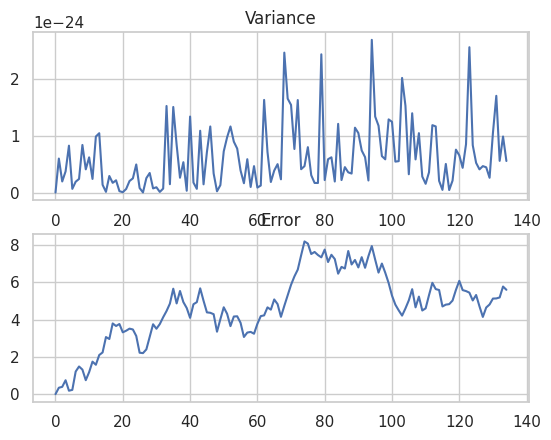

In [113]:
print(len(communicate_indices))
plt.subplot(2, 1, 2)
plt.plot(errors)
plt.scatter(communicate_indices, [errors[i] for i in communicate_indices], c='r')
plt.title("Error")
plt.subplot(2, 1, 1)
plt.plot(variances)
plt.scatter(communicate_indices, [variances[i] for i in communicate_indices], c='r')
plt.title("Variance")
plt.show()

In [114]:
waypoints_followed=0

for i in range(len(traj_errors)):
    if traj_errors[i]<7:
        waypoints_followed+=1
print(waypoints_followed)

print("mean absolute error: ", np.mean(traj_errors))

23
mean absolute error:  41.21979980542044


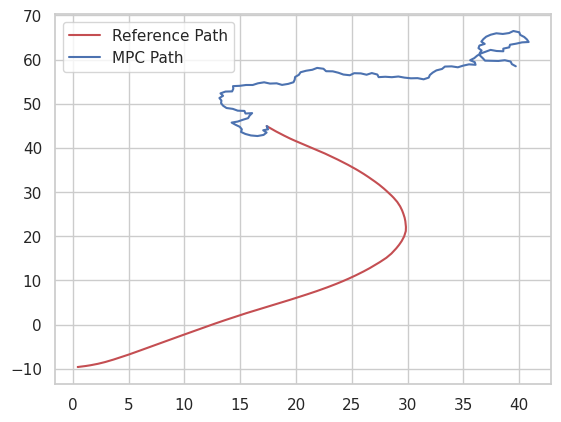

In [115]:
plt.plot(final_path[:, 0], final_path[:, 1], "r", label="Reference Path")
plt.plot(np.array(car_positions)[:, 0], np.array(car_positions)[:, 1], "b", label="MPC Path")
plt.legend()
plt.show()

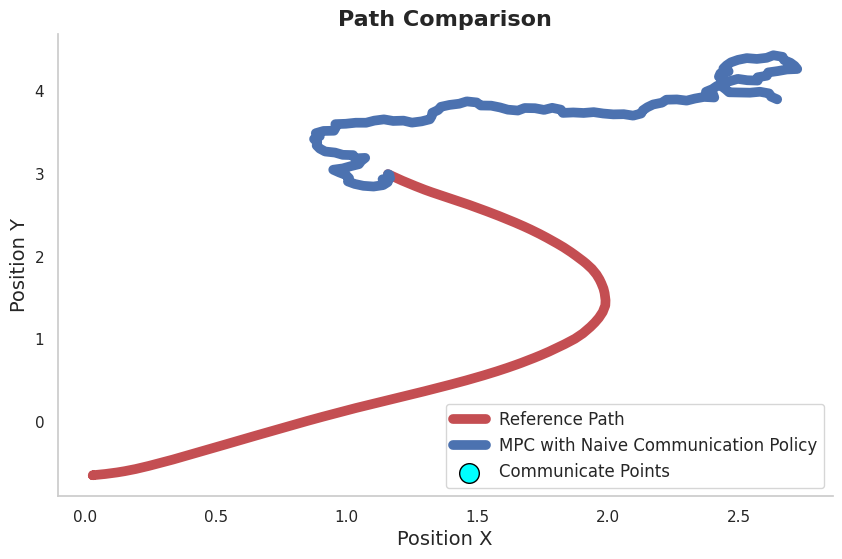

In [116]:

import seaborn as sns
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the reference path
plt.plot(final_path[:, 0]/15, final_path[:, 1]/15, "r-", linewidth=7, label="Reference Path")

# Plot the MPC path
plt.plot(np.array(car_positions)[:, 0]/15, np.array(car_positions)[:, 1]/15, "b-", linewidth=7, label="MPC with Naive Communication Policy")

# Highlight communicate points
plt.scatter(np.array(car_positions)[communicate_indices, 0]/15, np.array(car_positions)[communicate_indices, 1]/15, c='cyan', s=200, edgecolor='black', label="Communicate Points", zorder=5)

# If you have a baseline path to plot, uncomment and adjust the following line:
# plt.plot(np.array(car_positions_baseline)[:, 0], np.array(car_positions_baseline)[:, 1], "g-", linewidth=2, label="Baseline Path")

# Add legend with custom font size
plt.legend(fontsize=12)

# Add titles and labels with custom font size for better readability
plt.title("Path Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Position X", fontsize=14)
plt.ylabel("Position Y", fontsize=14)

# Remove the top and right spines for a cleaner look
sns.despine()
plt.grid(False)
plt.show()